<a href="https://colab.research.google.com/github/itssofiarce/AA2-TP2-Alomar-Arce/blob/main/ej_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descripción:
En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.

Dataset:
https://www.tensorflow.org/datasets/catalog/xtreme_s


El dataset proporcionado incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.

Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir el idioma correspondiente.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

# Librerías

In [1]:
#rm -rf data

In [2]:
!pip install tensorflow

In [3]:
!pip install pydub

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import tensorflow as tf
import tensorflow_datasets as tfds #  La versión estable, lanzada cada pocos meses.
import pandas as pd
from typing import Optional
from tensorflow_datasets.core import dataset_info # de aca viene el dataset

# Construcción y carga del Dataset


In [5]:
tfds.builder('xtreme_s').info # full_name

tfds.core.DatasetInfo(
    name='xtreme_s',
    full_name='xtreme_s/fleurs.af_za/2.0.0',
    description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    XTREME-S covers four task families: speech recognition, classification, speech-to-text translation and retrieval. Covering 102
    languages from 10+ language families, 3 different domains and 4
    task families, XTREME-S aims to simplify multilingual speech
    representation evaluation, as well as catalyze research in “universal” speech representation learning.
    
    In this version, only the FLEURS dataset is provided, which covers speech
    recognition and speech-to-text translation.
    """,
    config_description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    """,
    homepage='https://arxiv.org/abs/2205.12446',
    data_dir=PosixGPa

In [6]:
!rm -rf audio_sets

In [7]:
DATASET_PATH = 'data'

data_dir = pathlib.Path(DATASET_PATH)
lan = {'español':'es_419', 'ingles': 'en_us', 'frances':'fr_fr', 'japones': 'ja_jp'}

In [8]:
#for key, value in lan.items():
#    # Traigo solamente una parte del subset de test para agilizar la carga
#    tfds.load(f'xtreme_s/fleurs.{value}', split='test[:1%]', shuffle_files=False, data_dir=data_dir / key)
#
#    # Limpiar y quedarme unicamente con los audios que me insteresan
#    !mv data/{key}/downloads/audio data/{key}
#    !rm -rf data/{key}/downloads
#    !rm -rf data/{key}/xtreme_s


In [10]:
from google.colab import drive
drive.mount('/content/drive')
# Con dataset reducido
df_audio = ('/content/drive/MyDrive/dataset_reducido')

Mounted at /content/drive


In [11]:
!rm -rf /content/audio_sets

In [12]:
! [ ! -d /content/audio_sets ] &&  mkdir /content/audio_sets
! cp -r /content/drive/MyDrive/dataset_reducido/* /content/audio_sets/

In [13]:
drive.flush_and_unmount() # para liberar espacio

In [14]:
df = '/content/audio_sets'
data_dir = pathlib.Path(df)

# Distribuciones de las clases


In [15]:
for dir in os.listdir(df):
    print(f'{dir}: {len(os.listdir(os.path.join(df, dir)))}')

frances: 200
ingles: 200
español: 200
japones: 200


Las clases estan balanceadas.

# Analisis Exploratorio


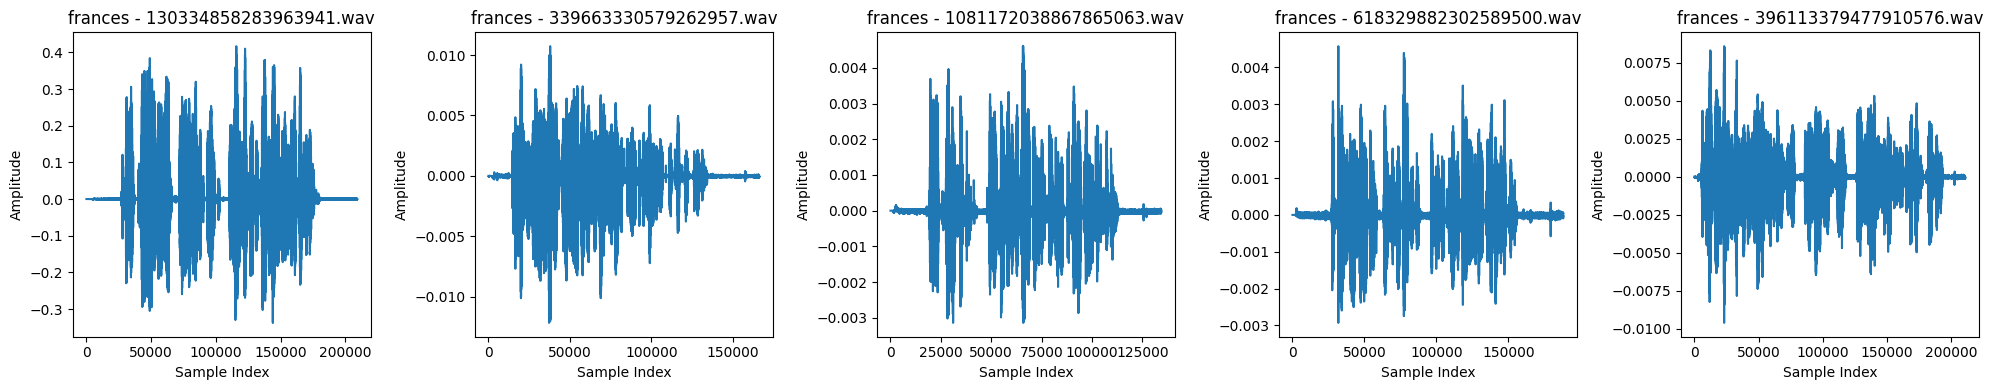

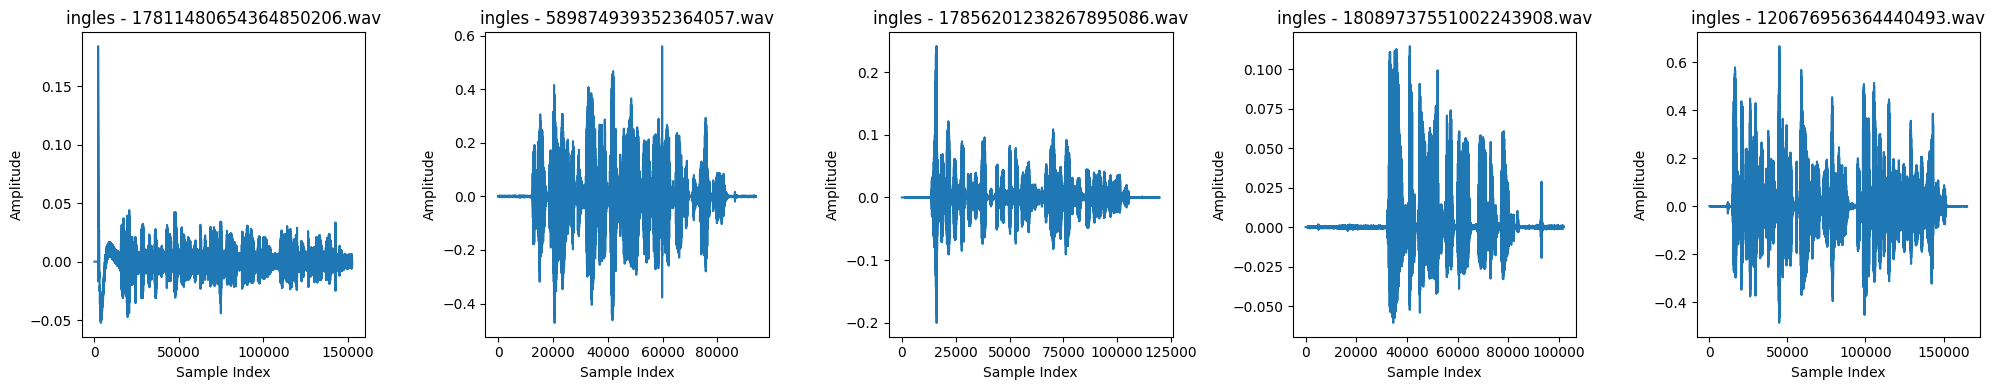

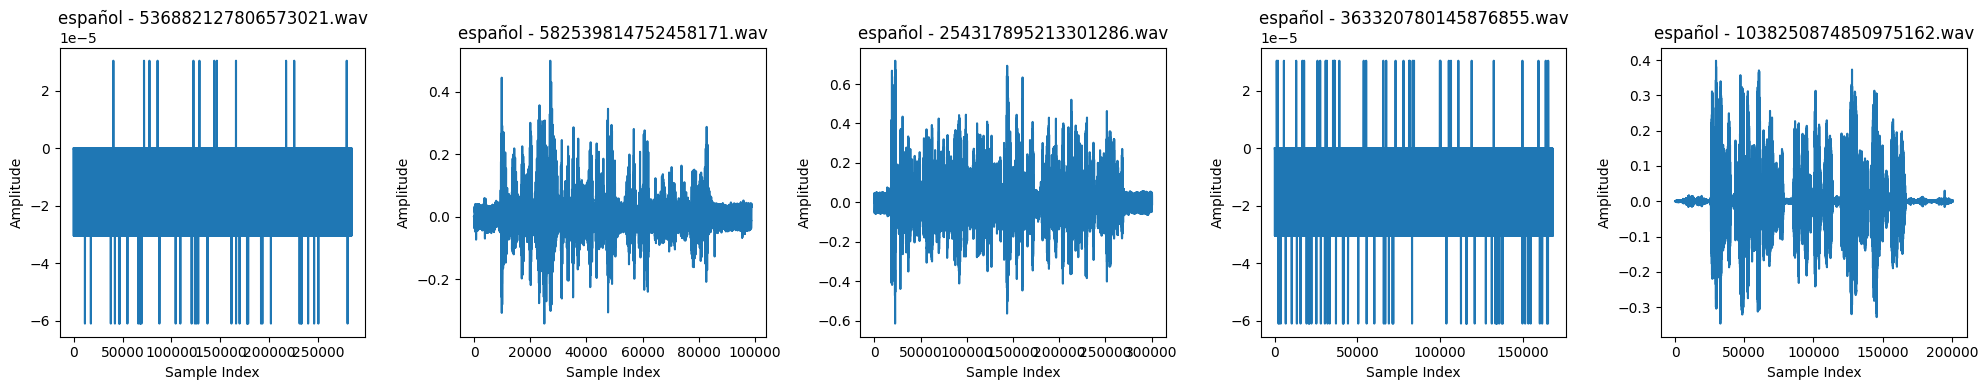

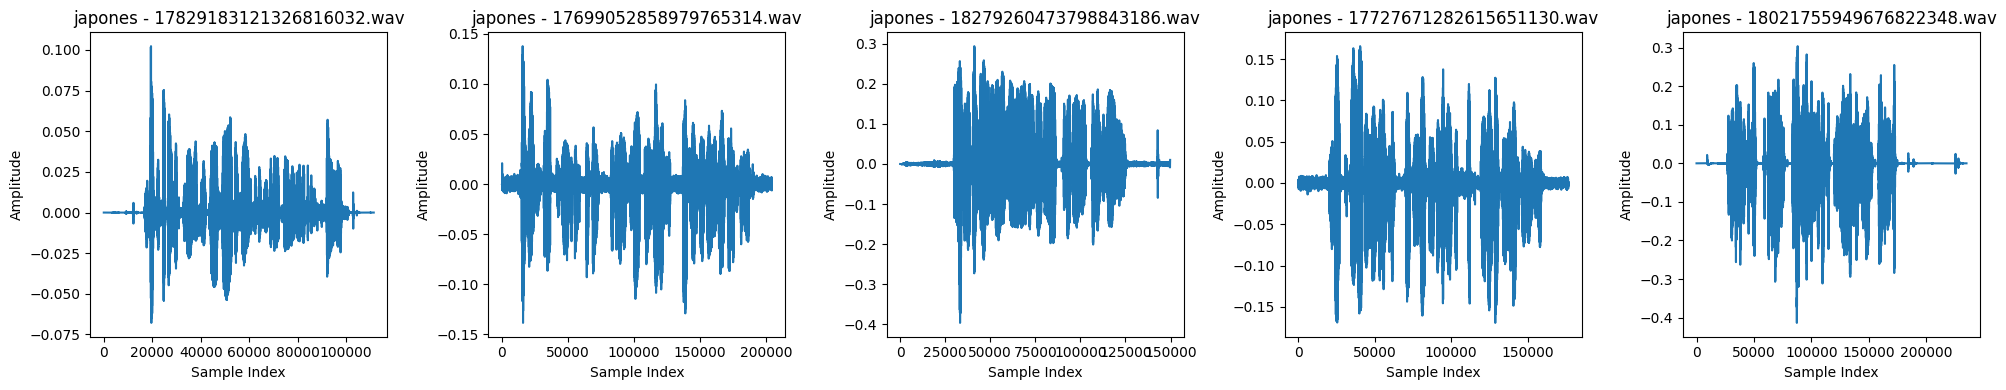

In [16]:
for dir in os.listdir(df):
    current_dir_path = os.path.join(df, dir)
    plt.figure(figsize=(20, 4))

    count = 1

    for wav in os.listdir(current_dir_path):
        if wav.endswith(".wav"):
            wav_path = os.path.join(current_dir_path, wav)
            audio = tf.audio.decode_wav(tf.io.read_file(wav_path))[0]
            plt.subplot(1, 5, count)
            plt.plot(audio.numpy())
            plt.title(f'{dir} - {wav}')
            plt.xlabel('Sample Index')
            plt.ylabel('Amplitude')

            count += 1
            if count > 5:
                break

    plt.tight_layout()
    plt.show()

Segun los los primeros 5 wav files de cada idioma, la longitud de los audios varían entre 10kHz y 30kHz vemos la dimension de los audios.

In [17]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=125000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 800 files belonging to 4 classes.
Using 640 files for training.
Using 160 files for validation.

label names: ['español' 'frances' 'ingles' 'japones']


In [18]:
train_ds.element_spec

(TensorSpec(shape=(None, 125000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

**shape=(None, 16000, None)**
  - Batch Size: No tiene
  - Audio Samples: No seteamos nigun output_sequence_length, por lo que a las secuencias del mismo bache se les agregó padding de la longitud del audio mas largo.
  - Numero de canales: Mono

**dtype=tf.int32:**
 - Tipo de Dato: Int32

**name=None**
  - Nombre: No tiene


Al ser audios mono, vamos a dropear el 3 componente de shape para mejorar la eficiencia y compatibilidad a la hora de entrenar el modelo con las capas que esperan 2D.


In [19]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Con .shard() spliteamos el dataset de validacion en dos mitades (num_shards=2), la primer mitad se la asignamos a test (index=0) y la segunda a validacion (index=1). Esto lo hacemos para subsanar a *audio_dataset_from_directory* ya que solo devuelve hasta dos sets (train y validación) y poder así obtener métricas mas significativas de nuestro modelo.

In [20]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Verificamos que el shape haya quedado de dos dimensiones.

In [21]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 125000)
(64,)


Ploteamos nuevamente las ondas de los audios.

In [22]:
example_labels

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([2, 0, 3, 0, 2, 0, 1, 3, 1, 2, 0, 0, 1, 0, 2, 3, 0, 1, 3, 3, 1, 2,
       2, 2, 2, 1, 2, 3, 3, 0, 2, 2, 2, 0, 1, 3, 2, 1, 1, 2, 2, 2, 3, 2,
       3, 2, 1, 2, 1, 1, 3, 0, 3, 2, 2, 1, 1, 3, 1, 0, 0, 1, 0, 1],
      dtype=int32)>

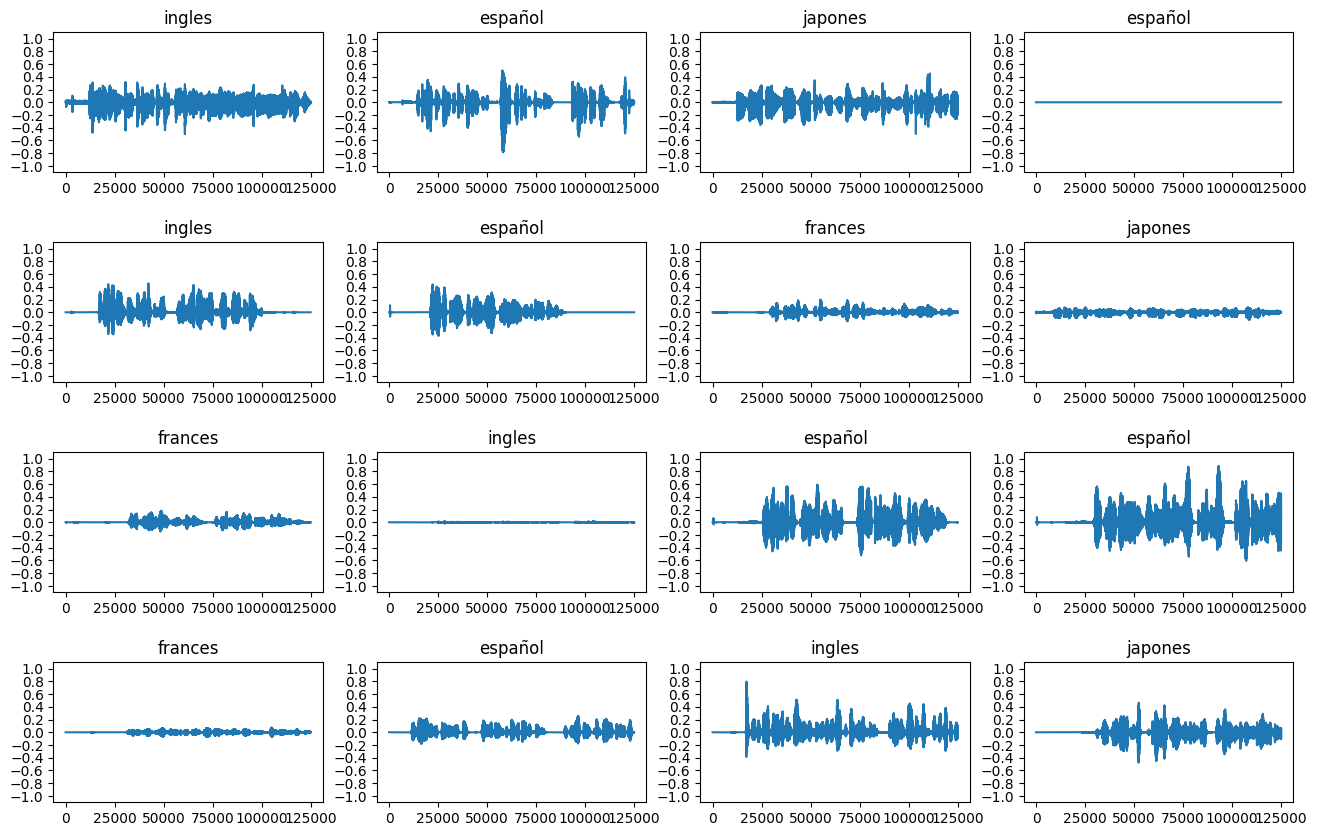

In [23]:
plt.figure(figsize=(16, 10))
rows = 4
cols = 4
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.subplots_adjust(hspace=0.5)
  plt.ylim([-1.1, 1.1])

Al reducir los canales las ondas se vuelven mas "simples" en algunos clips hasta parece no haber sonido. Seguiremos por convertirlas en espectogramas y observar el cambio de frecuencias a través del tiempo. Y poder entrar a nuestro modelo con esas imagenes representadas en 2D.

# Espectogramas


In [24]:
def get_spectrogram(waveform):
  ''' Params:
      - waveform: los clips de los audios de la misma longitud. (nuestro dataset fue armado así)'''
  # STFT a diferencia de fft splitea la señal en ventans de timepo y calcula la transformadad de fourier para cada una, preservando algo del tiempo.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128) # el frame_length y el frame_step deben ser de forma tal que la "imagen" del espectograma sea casi cuadrada para que ...
  spectrogram = tf.abs(spectrogram) # magnitud del spectograma
  # Agrego una dimension de "canales" para que el se pueda usar la imagen del espectograma como input en las redes convolucionales
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [25]:
label_names[example_labels]

array(['ingles', 'español', 'japones', 'español', 'ingles', 'español',
       'frances', 'japones', 'frances', 'ingles', 'español', 'español',
       'frances', 'español', 'ingles', 'japones', 'español', 'frances',
       'japones', 'japones', 'frances', 'ingles', 'ingles', 'ingles',
       'ingles', 'frances', 'ingles', 'japones', 'japones', 'español',
       'ingles', 'ingles', 'ingles', 'español', 'frances', 'japones',
       'ingles', 'frances', 'frances', 'ingles', 'ingles', 'ingles',
       'japones', 'ingles', 'japones', 'ingles', 'frances', 'ingles',
       'frances', 'frances', 'japones', 'español', 'japones', 'ingles',
       'ingles', 'frances', 'frances', 'japones', 'frances', 'español',
       'español', 'frances', 'español', 'frances'], dtype='<U8')

In [26]:
clean_test=[]
i = 0
while len(clean_test) < 4:
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  # Si ya mostré un audio, entonces sigo buscando uno distinto
  if label not in clean_test:
    clean_test.append(label)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=20000)) # rate es la velocidad mientras mas chico, mas lento.
  else:
    pass
  i += 1

Label: ingles
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Label: español
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Label: japones
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Label: frances
Waveform shape: (125000,)
Spectrogram shape: (975, 129, 1)
Audio playback


Graficamos

In [27]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  if ax == None:
    ax = plt.gca()
  ax.pcolormesh(X, Y, log_spec)

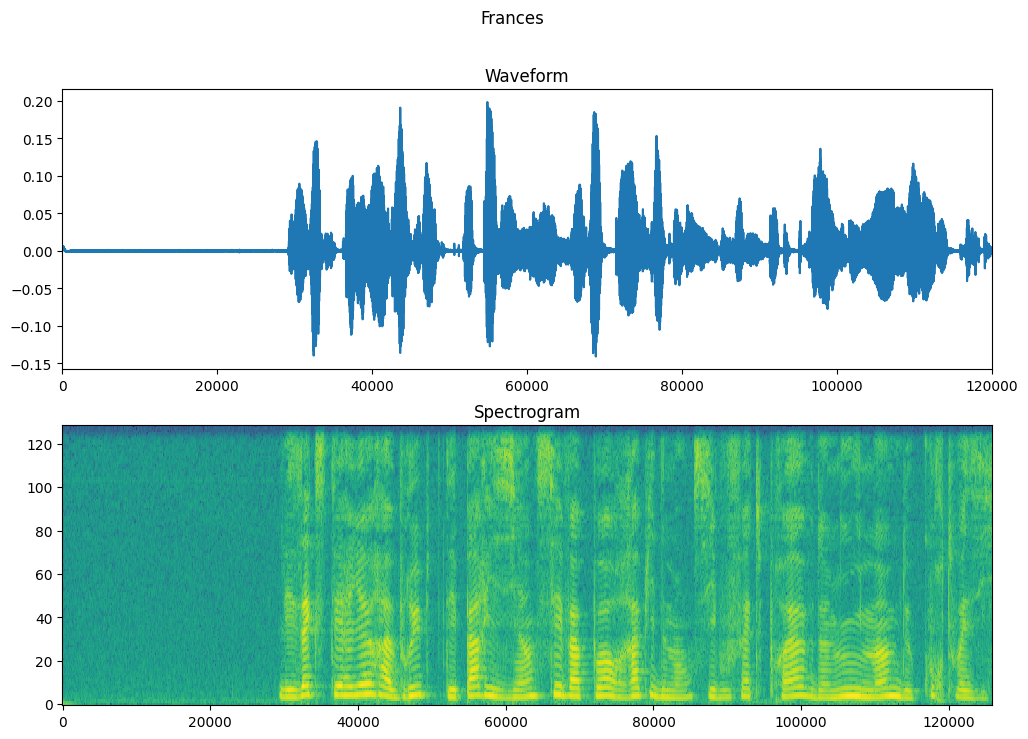

In [28]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 120000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Armamos nuestro dataset de espectogramas


In [29]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [30]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [31]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  # Decode the spect_labels
  print(example_spect_labels.shape)
  print(example_spect_labels)
  break

(64,)
tf.Tensor(
[2 2 3 0 2 1 3 3 0 1 2 1 3 3 3 3 1 3 2 3 3 0 1 0 0 2 3 0 3 3 3 0 2 1 2 1 3
 0 1 1 3 1 3 1 2 0 0 1 0 3 2 1 0 3 3 0 0 2 1 1 3 0 1 2], shape=(64,), dtype=int32)


# pending to fix


In [32]:
#rows = 3
#cols = 3
#n = rows*cols
#fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
#
#clean_spec=[]
#i=0
#while i != 10:
#  print(i, "hello")
#  label = label_names[example_labels[i]]
#
#  # Si ya mostré un audio, entonces sigo buscando uno distinto
#  if label not in clean_spec:
#
#    clean_spec.append(label)
#    r = i // cols
#    c = i % cols
#    ax = axes[r][c]
#    plot_spectrogram(example_spectrograms[i].numpy(), ax)
#    ax.set_title(label_names[example_spect_labels[i].numpy()])
#    ax.axis('off')
#
#  i += 1
#  pass
#
#plt.show()

# Modelo Convolucional

In [33]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [34]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (975, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,643,847 (6.27 MB)

 Trainable params: 1,643,844 (6.27 MB)

 Non-trainable params: 3 (16.00 B)

In [35]:
input_shape = example_spectrograms.shape[1:]  # Original line
# input_shape is (129, 1) - missing the batch size dimension which is automatically added
# Add channel dimension explicitly:
input_shape = (input_shape[0], input_shape[1], 1)  # Modified line: Now (129, 1, 1)

print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, activation='relu', padding='same'),  # Add padding to handle boundary effects
    layers.Conv2D(64, 3, activation='relu', padding='same'),  # Add padding to handle boundary effects
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (975, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,135,367 (8.15 MB)

 Trainable params: 2,135,364 (8.15 MB)

 Non-trainable params: 3 (16.00 B)

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 30
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.2928 - loss: 1.4189 - val_accuracy: 0.2188 - val_loss: 1.3896
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3963 - loss: 1.2420 - val_accuracy: 0.4531 - val_loss: 1.2059
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5132 - loss: 1.1361 - val_accuracy: 0.4375 - val_loss: 1.1480
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5039 - loss: 1.0867 - val_accuracy: 0.4531 - val_loss: 1.1390
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6249 - loss: 0.9682 - val_accuracy: 0.5312 - val_loss: 1.0699
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6445 - loss: 0.9011 - val_accuracy: 0.5312 - val_loss: 1.0513
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6964 - loss: 0.7942 - val_accuracy: 0.5469 - val_loss: 1.2088
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6748 - loss: 0.7977 - val_accuracy: 0.5469 -

# Analisis de las métricas


Text(0, 0.5, 'Accuracy [%]')

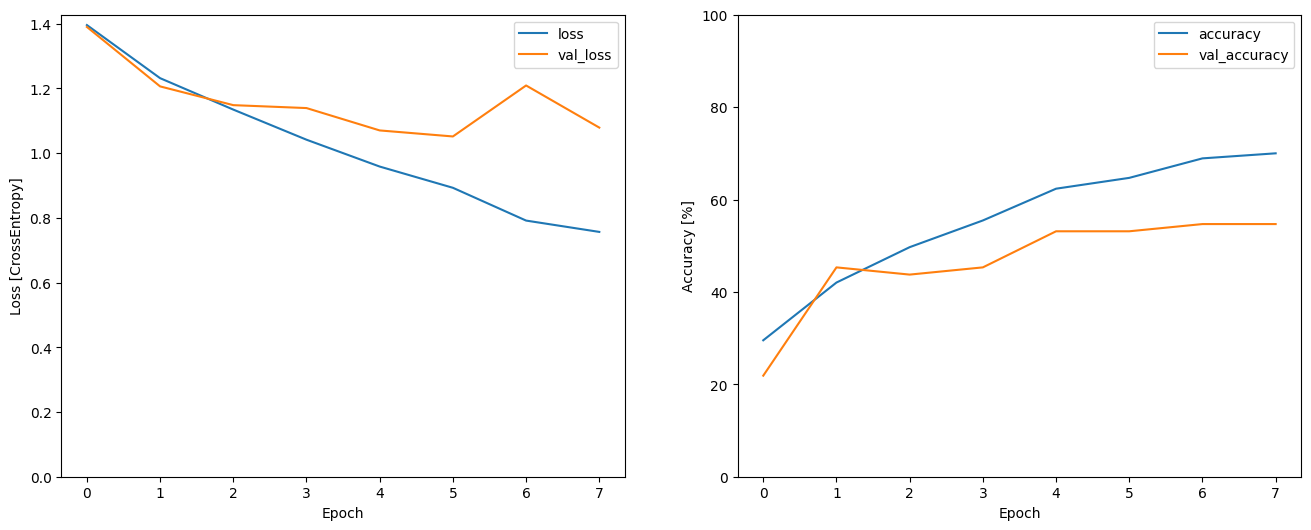

In [38]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

El modelo esta overfitteado de los datos de train ya que el accuracy es menor para el dataset de train y el loss es menor para este tambien.

In [39]:
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6007 - loss: 1.0259


{'accuracy': 0.6041666865348816, 'loss': 1.0116443634033203}

Para los datos no vistos el modelo convolucional tiene un accuracy de 59%

In [40]:
y_pred = model.predict(test_spectrogram_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


In [41]:
y_pred = tf.argmax(y_pred, axis=1)

In [42]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

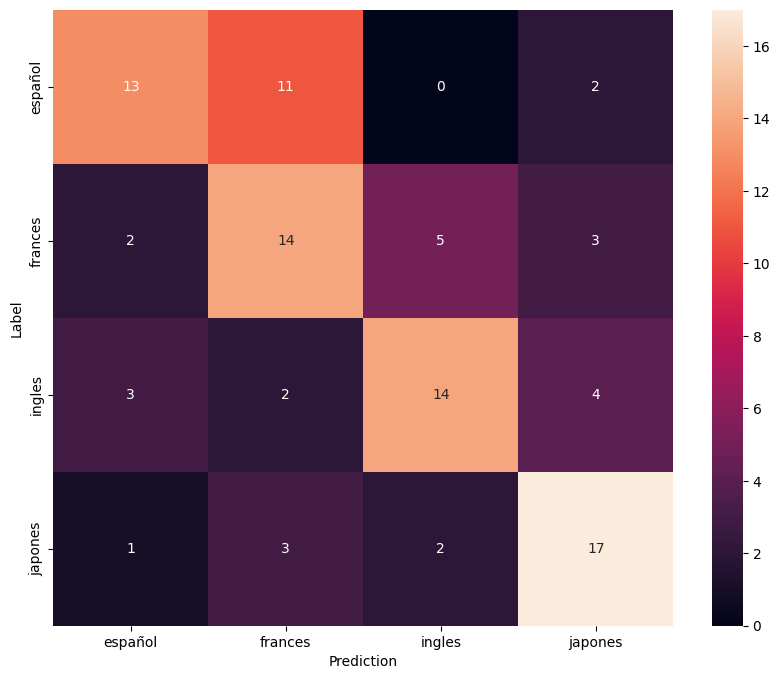

In [43]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    español       0.68      0.50      0.58        26
     frances       0.47      0.58      0.52        24
      ingles       0.67      0.61      0.64        23
     japones       0.65      0.74      0.69        23

    accuracy                           0.60        96
   macro avg       0.62      0.61      0.61        96
weighted avg       0.62      0.60      0.60        96



Conclusión del modelo convolucional en test de validación:

Es muy bueno para las instancias de "japones", tiene una precisión del 92% pero su capacidad para detectar correctamente los casos de japonés (recall) es solamente del 52%.
Tampoco confunde las clases de ffrances e ingles con las de los demas idiomas(recall del 79% y 65%). Pero para el español, confunde las instancias de en mayor cantidad con las de frances (recall bajo del 38%)


# Modelo Recurrente

In [45]:
img_height, img_width = 50, 50
segment_length = 10  # Número de frames a extraer por segmento
segment_stride = 5  # Desplazamiento entre segmentos

# Hipotesis inicial

In [46]:
my_old_spec = example_spectrograms.numpy()
new_partitioned, label = [], []

segmento = (len(my_old_spec) - segment_length) // segment_stride + 1
for seg in range(segmento):
    start = seg * segment_stride
    end = start + segment_length
    segment = my_old_spec[start:end]
    if len(segment) == segment_length:
        new_partitioned.append(segment)
        label.append(example_spect_labels.numpy())

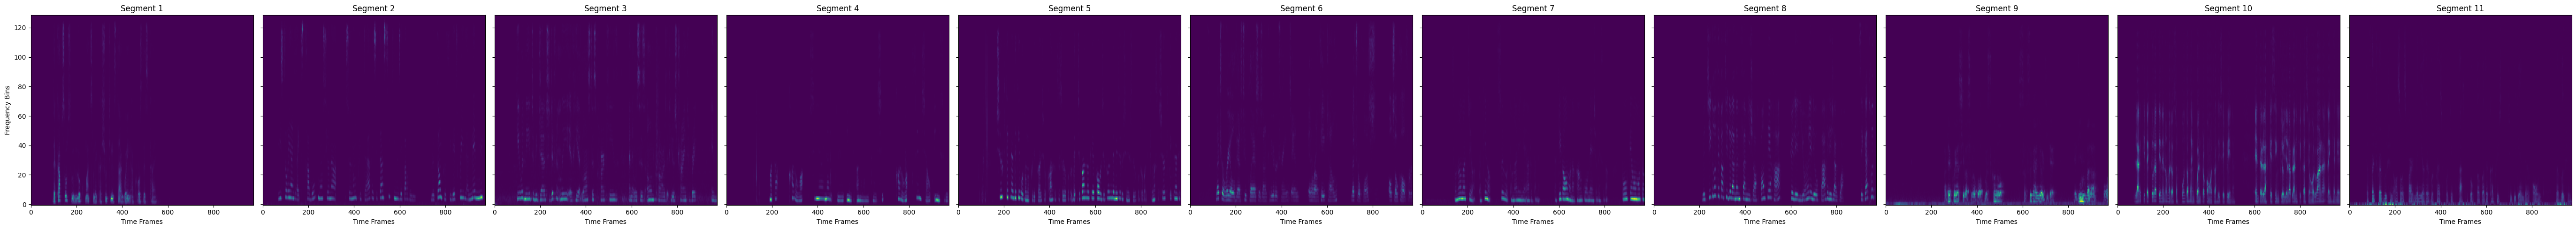

In [47]:
# Assuming 'new_partitioned' is a list of NumPy arrays
num_segments = len(new_partitioned)

# Create a figure and subplots
fig, axes = plt.subplots(1, num_segments, figsize=(5 * num_segments, 5), sharey=True)

# Iterate through segments and plot on subplots
for i, segment in enumerate(new_partitioned):
    segment_to_display = segment[0, :, :, 0]  # Assuming first channel
    segment_to_display = segment_to_display.T  # Transpose

    axes[i].imshow(segment_to_display, aspect='auto', origin='lower')
    axes[i].set_title(f"Segment {i+1}")
    axes[i].set_xlabel("Time Frames")

    # Only label the y-axis for the first subplot
    if i == 0:
        axes[i].set_ylabel("Frequency Bins")

plt.tight_layout()
plt.show()

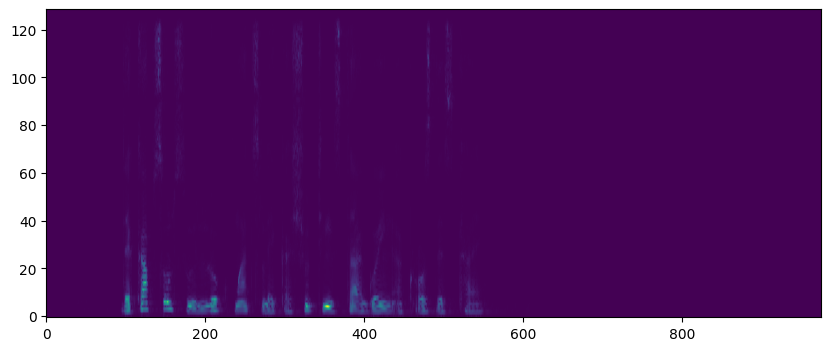

In [48]:
# Plot the example_spectorgram
plt.figure(figsize=(10, 4))

# Select the correct dimensions and transpose
# Assuming the dimensions are (batch, frequency, time, channels)
spectrogram_data = example_spectrograms[0].numpy().squeeze()  # Remove the channel dimension if it's 1
spectrogram_data = spectrogram_data.T  # Transpose to (time, frequency)

plt.imshow(spectrogram_data, aspect='auto', origin='lower')
plt.show()

# Carga de data set para recurrentes

In [49]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [50]:
def load_video_classification_dataset(spect_ds, img_height, img_width, segment_length, segment_stride):

  X, y = [], []
  i = 0
  for audio, label in spect_ds:
    # I change the resolution of the audio spectogram
    audio = tf.image.resize(audio, [img_height, img_width])
    # Change to channel equal to 3, but keep it in color
    audio = tf.image.grayscale_to_rgb(audio)
    my_old_spec = audio.numpy()

    num_segments = (len(my_old_spec) - segment_length) // segment_stride + 1
    # Itero por mi spectograma
    for seg in range(num_segments):
      start = seg * segment_stride
      end = start + segment_length
      segment = my_old_spec[start:end]
      if len(segment) == segment_length:
        X.append(segment)
        y.append(label[i])
    i += 1
    # Convierto mi lista temporal en array y agrego al ds a retornar
  X = np.array(X)
  y = to_categorical(y, num_labels)
  return X, y



In [51]:
X, y = load_video_classification_dataset(train_spectrogram_ds, img_height, img_width, segment_length, segment_stride)

In [52]:
# Mezclar los datos antes de dividirlos en entrenamiento y validación
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train.shape

(88, 10, 50, 50, 3)

In [54]:
y_train.shape

(88, 4)

In [55]:
X_train[0].shape

(10, 50, 50, 3)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, LSTM, Dense

In [57]:
model_rnn = Sequential()
# Capas convolucionales dentro de TimeDistributed
model_rnn.add(TimeDistributed(Conv2D(64, (2, 2), strides=(1,1),activation='relu'), input_shape=(segment_length, img_height, img_width, 3)))
model_rnn.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_rnn.add(TimeDistributed(MaxPooling2D((2,2))))
model_rnn.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_rnn.add(TimeDistributed(Conv2D(16, (3, 3), strides=(1,1),activation='relu')))
model_rnn.add(TimeDistributed(MaxPooling2D(2,2)))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(Flatten()))
model_rnn.add(TimeDistributed(Dropout(0.5)))
# Capa recurrente
model_rnn.add(LSTM(32, return_sequences=False, dropout=0.5))
# Capas de salida
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(num_labels, activation='softmax'))
# Resumen del modelo
model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 49, 49, 64)      │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 47, 47, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 23, 23, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 21, 21, 32)      │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 19, 19, 16)      │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 9, 9, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 9, 9, 16)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 1296)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 1296)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │         170,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,668 (811.20 KB)

 Trainable params: 207,636 (811.08 KB)

 Non-trainable params: 32 (128.00 B)

In [58]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [59]:
# Compilar el modelo
model_rnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo con callbacks
history = model_rnn.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=8,
                          callbacks=[early_stopping, model_checkpoint])

# Evaluación del modelo en el conjunto de validación
val_loss, val_accuracy = model_rnn.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 319ms/step - accuracy: 0.2703 - loss: 1.3971 - val_accuracy: 0.5000 - val_loss: 1.3672
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3023 - loss: 1.3904 - val_accuracy: 0.1818 - val_loss: 1.3891
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.1889 - loss: 1.4216 - val_accuracy: 0.3636 - val_loss: 1.3651
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4010 - loss: 1.3475 - val_accuracy: 0.3636 - val_loss: 1.3763
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3529 - loss: 1.3226 - val_accuracy: 0.3636 - val_loss: 1.3753
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4324 - loss: 1.2875 - val_accuracy: 0.3636 - val_loss: 1.3899
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3931 - loss: 1.4186 - val_accuracy: 0.3636 - val_loss: 1.3735
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3688 - loss: 1.3240 - val_accuracy: 0.3636 -